In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICE'] = ''
import random

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import torch

%load_ext autoreload
%autoreload 2

from importlib.util import find_spec
if find_spec("text_recognizer") is None:
    import sys
    sys.path.append('..')

from text_recognizer.data.iam_paragraphs import IAMParagraphs
from text_recognizer.data.iam_synthetic_paragraphs import IAMSyntheticParagraphs
from text_recognizer.data.iam_extended_paragraphs import IAMExtendedParagraphs

In [2]:
def _plot(image, figsize=(12,12), title='', vmin=0, vmax=255):
    plt.figure(figsize=figsize)
    if title:
        plt.title(title)
    plt.imshow(image, cmap='gray', vmin=vmin, vmax=vmax)

def convert_y_label_to_string(y, mapping, padding_index=3):
    return ''.join([mapping[int(i)] for i in y if i != padding_index])

In [3]:
from hydra import compose, initialize
from omegaconf import OmegaConf
from hydra.utils import instantiate

In [4]:
path = "../training/conf/datamodule/iam_extended_paragraphs.yaml"
with open(path, "rb") as f:
    cfg = OmegaConf.load(f)

In [5]:
# context initialization
with initialize(config_path="../training/conf/"):
    cfg = compose(config_name="config", overrides=["+experiment=conv_transformer_paragraphs"])
cfg = cfg.datamodule

/tmp/ipykernel_23754/3617549544.py:2: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../training/conf/"):


ConfigCompositionException: Multiple values for experiment. To override a value use 'override experiment: conv_transformer_paragraphs'

In [9]:
cfg

{'_target_': 'text_recognizer.data.iam_extended_paragraphs.IAMExtendedParagraphs', 'batch_size': 2, 'num_workers': 12, 'train_fraction': 0.95, 'pin_memory': False, 'transform': {'_target_': 'text_recognizer.data.transforms.paragraph.ParagraphStem', 'augment': True}, 'test_transform': {'_target_': 'text_recognizer.data.transforms.paragraph.ParagraphStem', 'augment': False}, 'target_transform': {'_target_': 'text_recognizer.data.transforms.pad.Pad', 'max_len': 682, 'pad_index': 3}, 'tokenizer': {'_target_': 'text_recognizer.data.tokenizer.Tokenizer', 'extra_symbols': ['\n']}}

In [11]:
datamodule = instantiate(cfg)
datamodule.prepare_data()
datamodule.setup()
print(datamodule)

2022-09-27 23:05:03.806 | INFO     | text_recognizer.data.iam_paragraphs:setup:101 - Loading IAM paragraph regions and lines for None...
2022-09-27 23:05:19.817 | INFO     | text_recognizer.data.iam_synthetic_paragraphs:setup:85 - IAM Synthetic dataset steup for stage None...


IAM Original and Synthetic Paragraphs Dataset
Num classes: 58
Dims: (1, 576, 640)
Output dims: (682, 1)
Train/val/test sizes: 20135, 66, 231
Train Batch x stats: (torch.Size([2, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0021), tensor(0.0268), tensor(0.8863))
Train Batch y stats: (torch.Size([2, 682]), torch.int64, tensor(1), tensor(52))
Test Batch x stats: (torch.Size([2, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0337), tensor(0.0770), tensor(0.8118))
Test Batch y stats: (torch.Size([2, 682]), torch.int64, tensor(1), tensor(57))



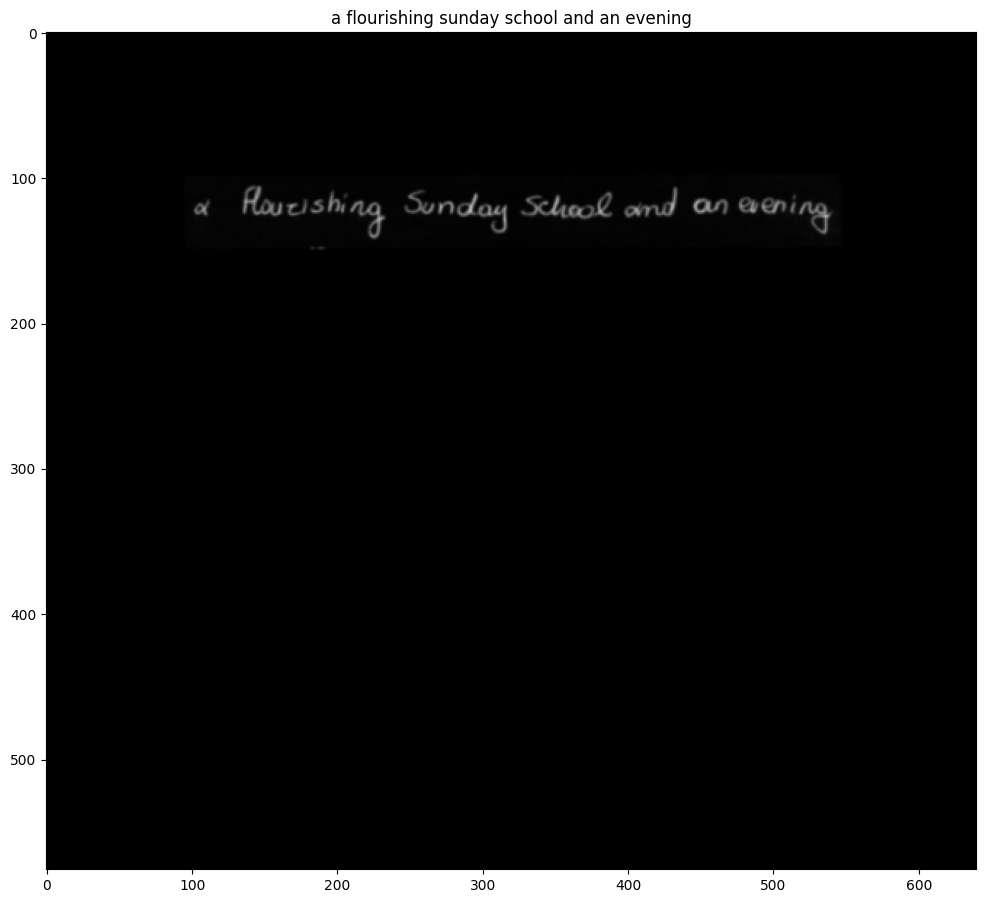

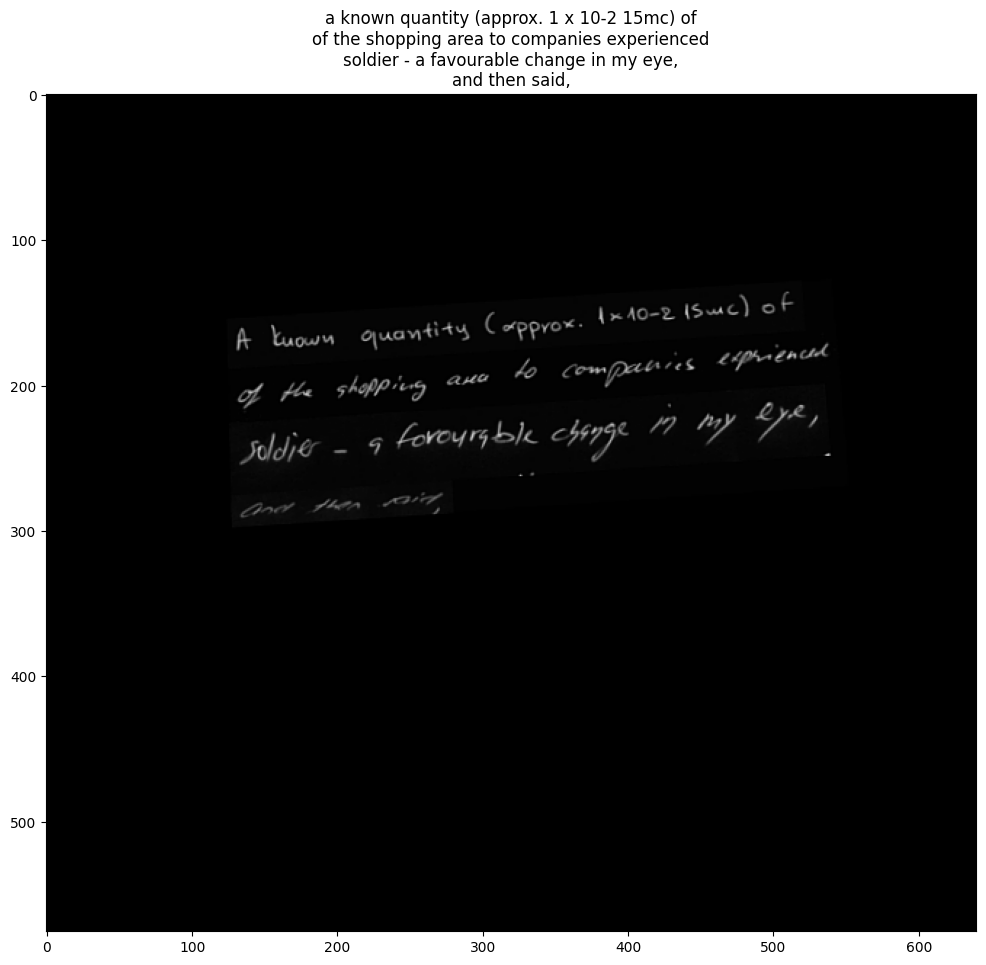

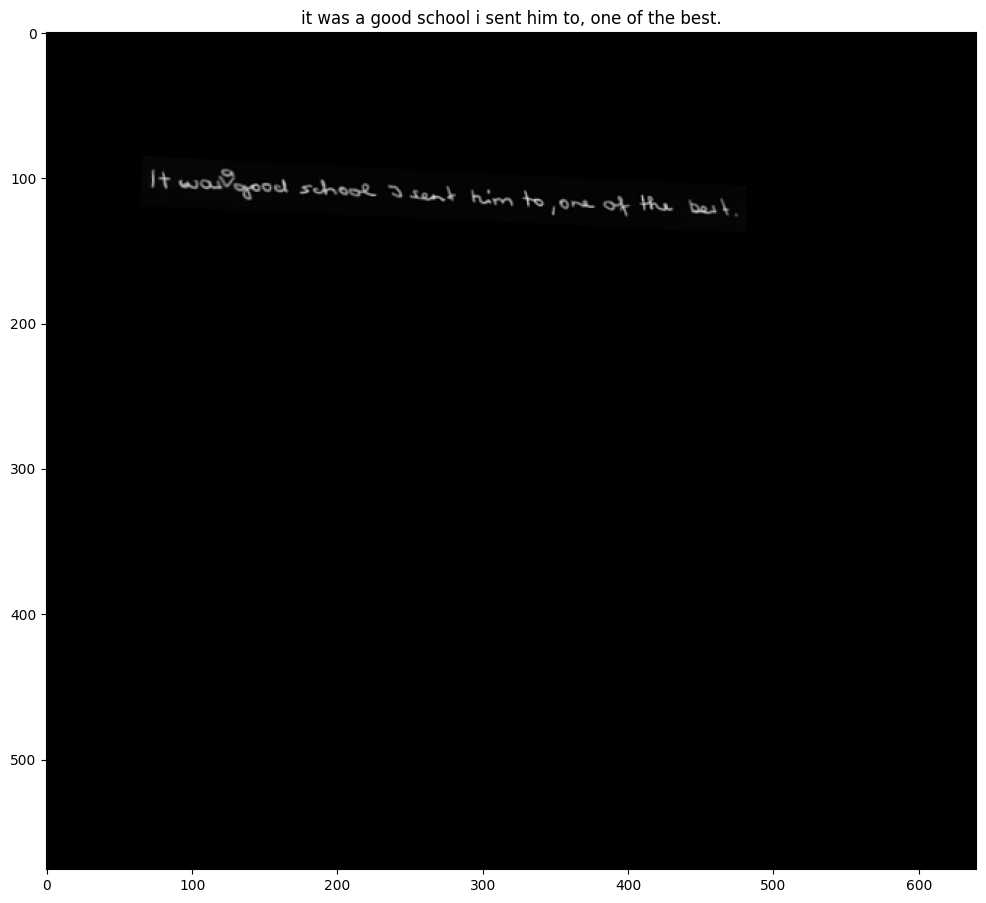

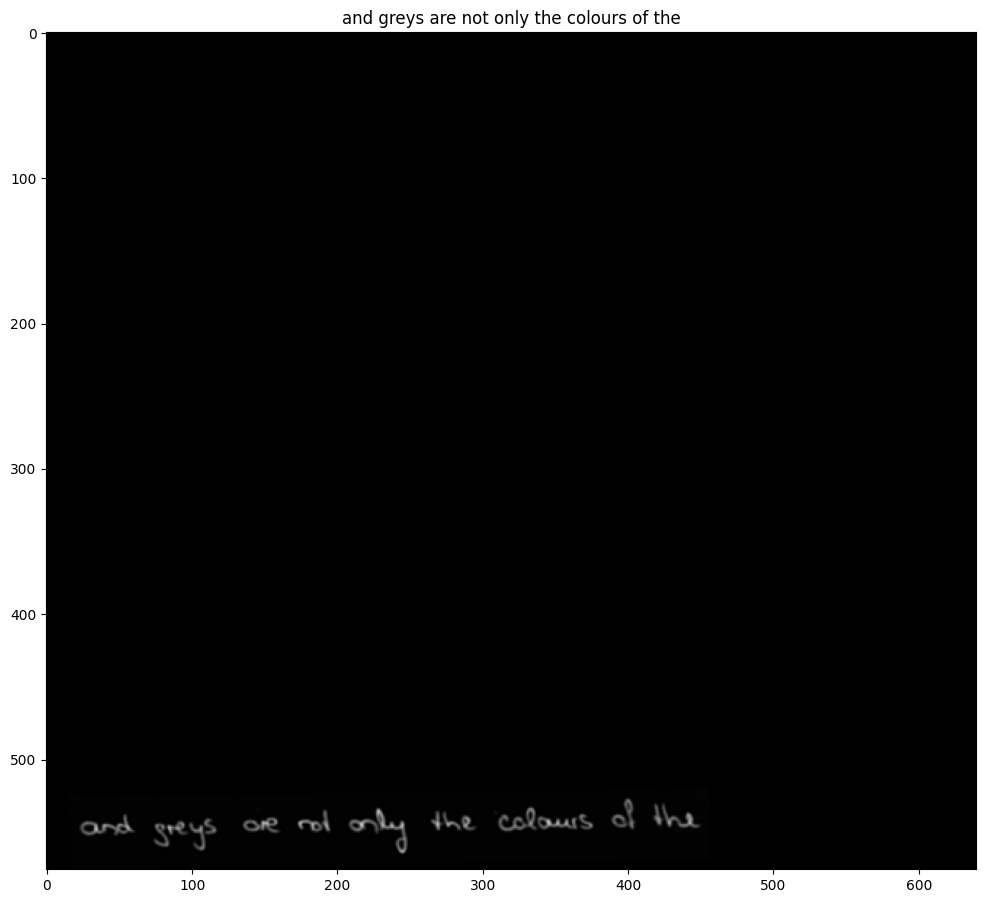

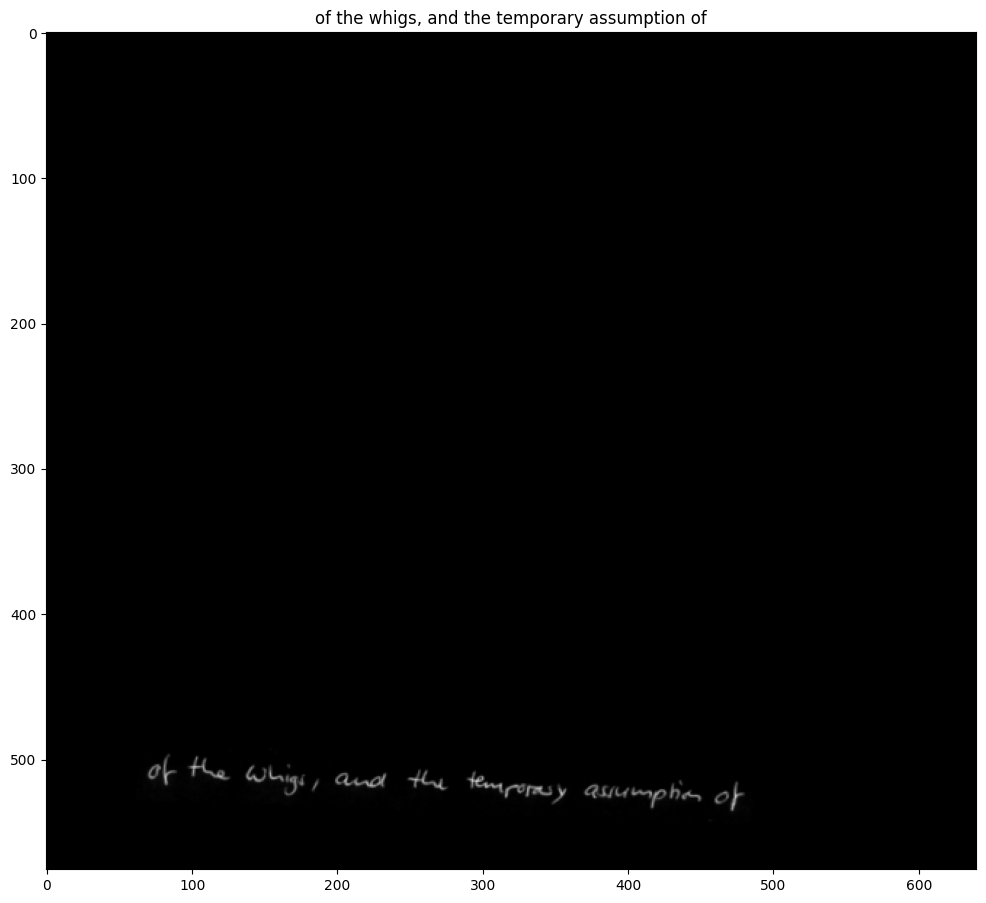

In [15]:
# Training
dataset = datamodule.data_train
for _ in range(5):
    i = random.randint(0, len(dataset))
    x, y = dataset[i]
    _plot(x[0], vmax=1, title=datamodule.tokenizer.decode(y))

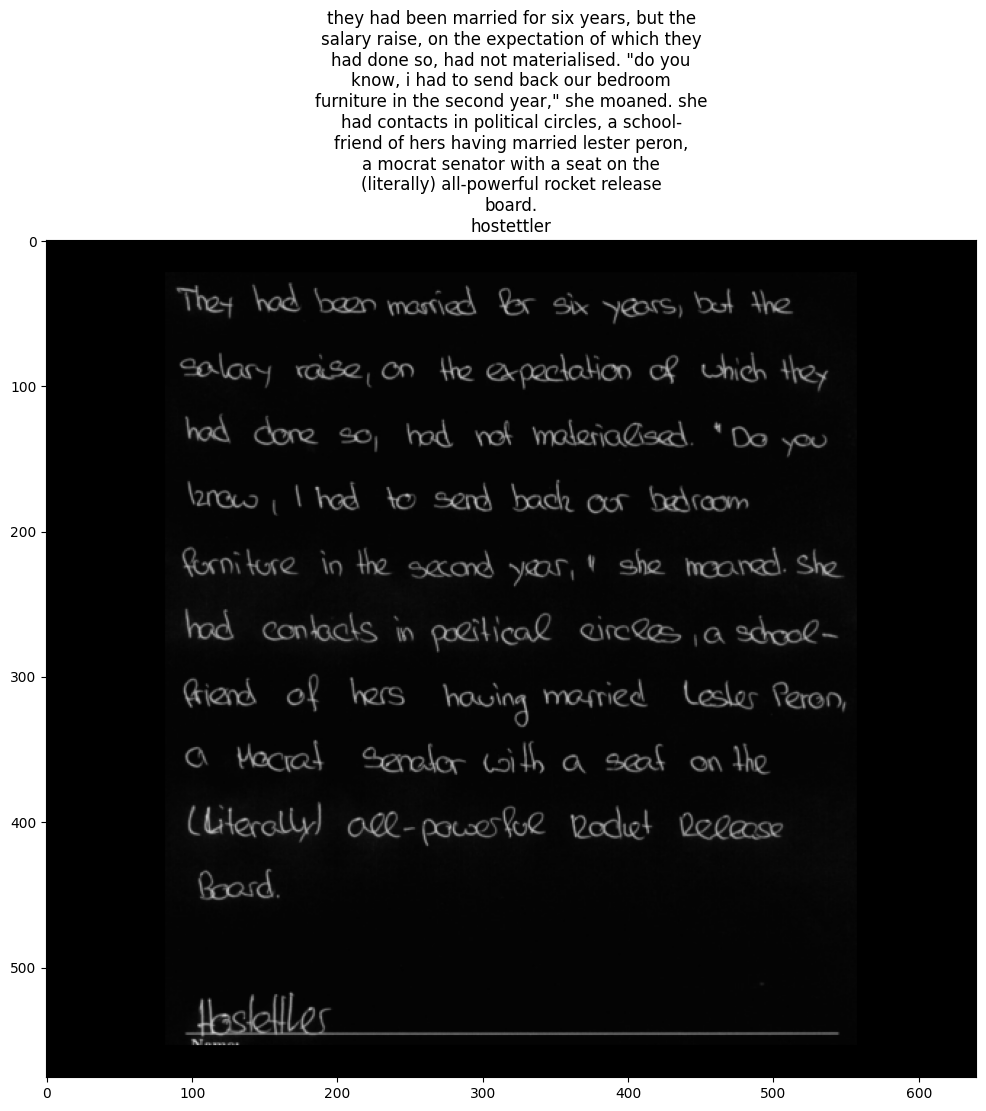

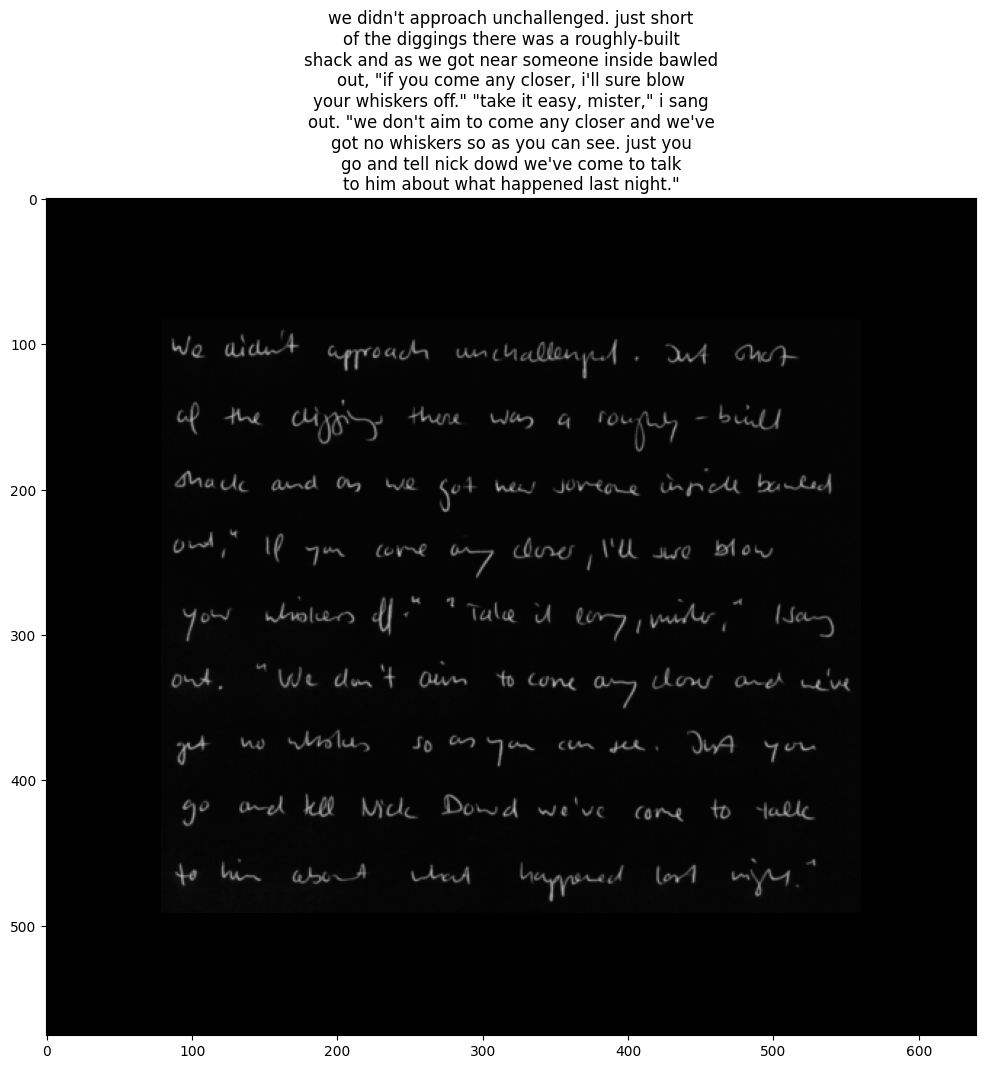

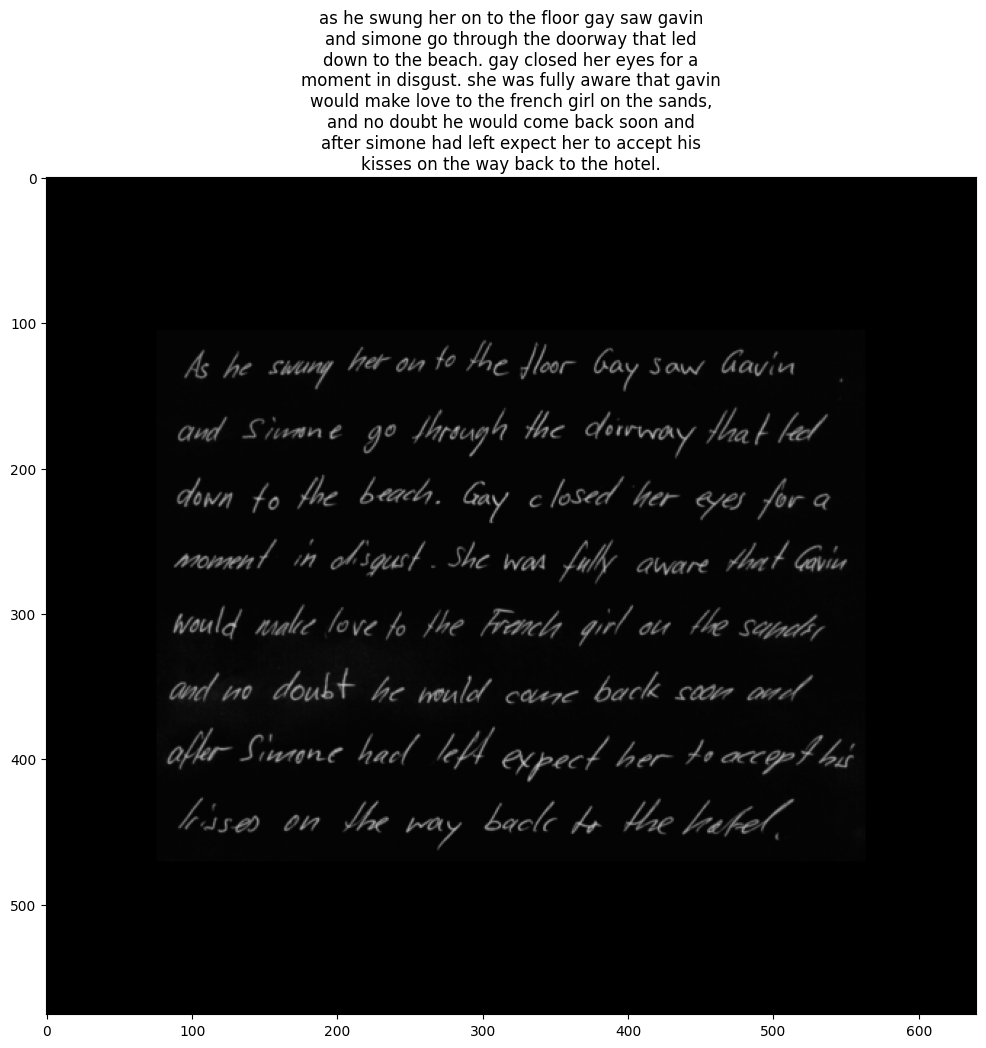

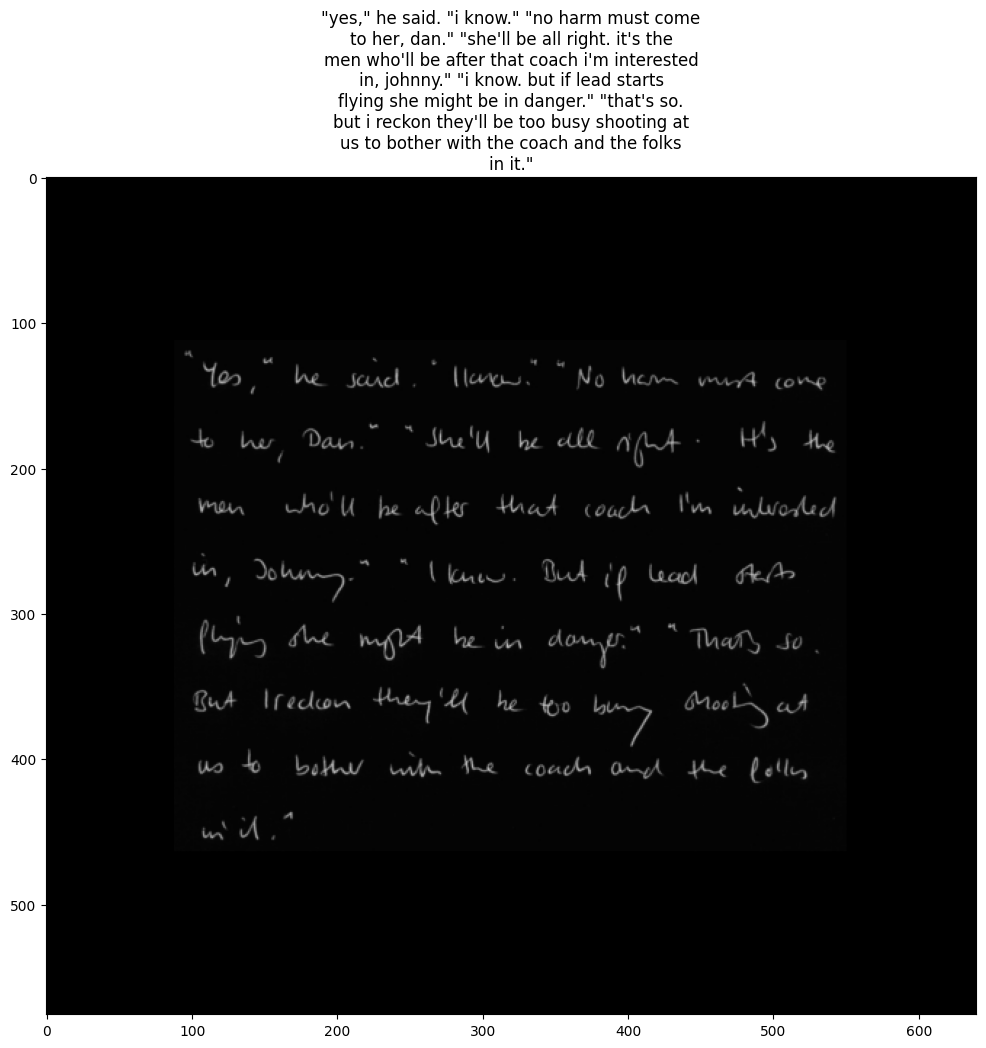

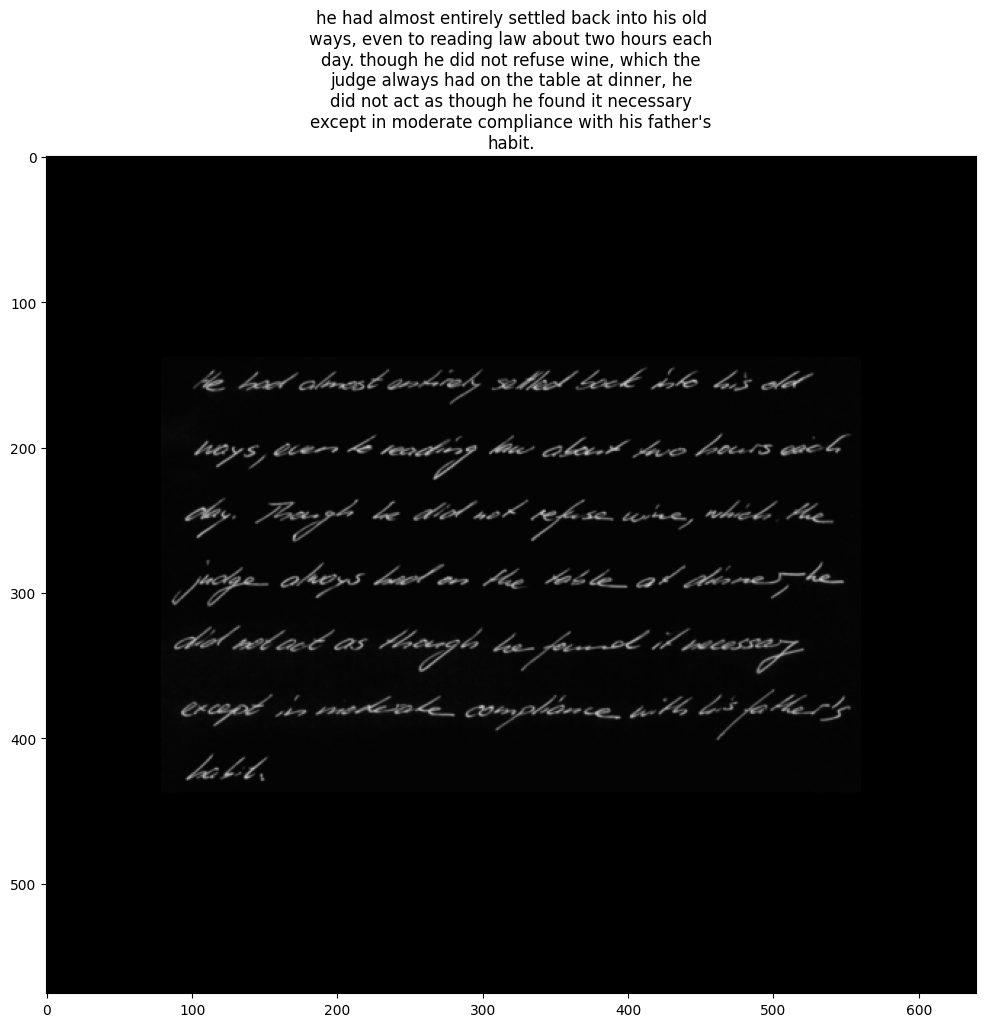

In [17]:
# Testing
dataset = datamodule.data_test
for _ in range(5):
    i = random.randint(0, len(dataset))
    x, y = dataset[i]
    _plot(x[0], vmax=1, title=datamodule.tokenizer.decode(y))